# <center>SNP predition</center>

## Author: Bartosz Lewandowski

# ------------------------------------------------------------------------------------------------------------

## Workflow 
    1. Understanding our data and quick review     
    2. Preprocessing 
    3. Building first neural network
    4. Checking results 
    5. Plots for our first neural network
    6. Bulding second neural network
    7. Checking results
    8. Plots for second NN
    9. Last NN using StratifiedKfold
    10. Results
    11. Summarizing results and choosing best neural network 

### Import of necessary function 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas_profiling 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.impute import KNNImputer
from pandas_profiling import ProfileReport
from keras import backend as K
from keras.layers import Dropout
from sklearn.metrics import roc_curve,auc

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
/usr/local/lib/python3.7

# 1. Data overview 

### Reading data

In [3]:
data = pd.read_csv('data/logreg.txt', sep=';', dtype={'genotype':'float32'})

In [3]:
data.head()

genotype   QUAL  DP   DP2     GQ  CALL BEFORE1 BEFORE2 BEFORE3 BEHIND1  \
0       1.0  87093  74  50.0   63.0     3       C       C       A       A   
1       1.0  56419  64   9.0  100.0     3       A       G       G       A   
2       1.0  40180  68  48.0    NaN     2       A       G       G       T   
3       1.0  33677  57  48.0    3.0     3       C       A       C       G   
4       1.0  78396  51  50.0   21.0     5       A       A       T       A   

  BEHIND2 BEHIND3  
0       A       A  
1       C       A  
2       A       A  
3       G       G  
4       A       A

### We are checking how many variables and observations we have. We can see that there are 12 variables, 1 dependant and 11 independant. The dependant variable is genotype. 

In [4]:
data.shape

(2294151, 12)

### We are checking how many good and bad predictions we have.

In [5]:
good_prediction = data[data['genotype'] == 1].shape[0]
bad_prediction = data[data['genotype'] == 0].shape[0]

In [6]:
print(str(round(good_prediction * 100 / (good_prediction + bad_prediction), 2)) + '% good SNP')
print(str(round(bad_prediction * 100 / (good_prediction + bad_prediction), 2)) + '% bad SNP')

96.74% good SNP
3.26% bad SNP


### Change genotype destingnation. We do that, becouse we want to search for 1 not for 0. 

In [7]:
data['genotype'][data['genotype'] == 0.0] = 2.0
data['genotype'][data['genotype'] == 1.0] = 0.0
data['genotype'][data['genotype'] == 2.0] = 1.0

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Becouse we read nucleotides as nucleotides triplets we merge those colmuns together as BEFORE and BEHIND

In [8]:
data['BEFORE'] = data['BEFORE1'] + data['BEFORE2'] + data['BEFORE3']
data['BEHIND'] = data['BEHIND1'] + data['BEHIND2'] + data['BEHIND3']
data = data.drop(['BEFORE1','BEFORE2','BEFORE3','BEHIND1','BEHIND2','BEHIND3'], axis=1)

### We use pandas_profiling to generete informations about our data. It's the best and easy way to do it. We can make it step by step, but for stuff like that this is sufficient.

### For a given dataset the pandas profiling package computes the following statistics:

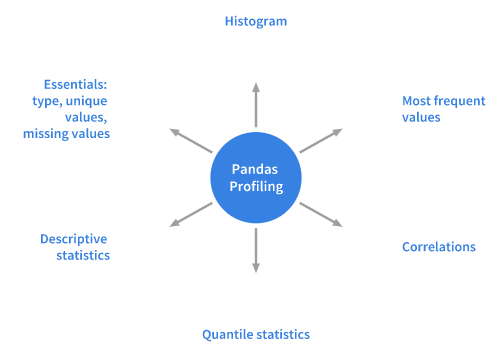

In [9]:
data.profile_report()

# 2. Preprocessing

## 2.1 Dealing with missing data.
### Knowing that thare is missing data in variable DP2 and GQ we need to do something with that. 
### We have a few ways to deal with it : 
* Delete those variables from our dataset
* Delete rows where is missing data
* We can do an imputation with mean, median, KNN, or even linear regression
* There is recommended way in deep learning to impute missing data with numer 0, or -9999, but when our variable is integer, or float it's not recommended then. 

### In our data we can see that in variable GQ there is 24.6% missing data, that's quite a lot. We can decide then to delete this variable from out dataset. In case of DP2 there is only 1% so we can make some imputation there. I decided to do it with mean, becouse KNN algorithm had some hardware problems. 

In [10]:
data['DP2']=data['DP2'].fillna(data['DP2'].mean())

### Deleting columns with missing data (GQ)

In [11]:
data = data.dropna(axis=1)

## Change strings into vectors by one hot encoding method using pd.get_dummies. 
### We need to do that, becouse neural networks is not able to read strings using keras. 

In [12]:
data = pd.get_dummies(data, prefix=['BEFORE', 'BEHIND'])

### Now we can check how many variables we have now. 

In [13]:
data.shape

(2294151, 135)

### Quick look at our data now. We have nucleotides triplets from before and after variables, if a given nucleotide trio was in row then there appears integer 1. 

In [14]:
data.head()

genotype   QUAL  DP   DP2  CALL  BEFORE_AAA  BEFORE_AAC  BEFORE_AAG  \
0       0.0  87093  74  50.0     3           0           0           0   
1       0.0  56419  64   9.0     3           0           0           0   
2       0.0  40180  68  48.0     2           0           0           0   
3       0.0  33677  57  48.0     3           0           0           0   
4       0.0  78396  51  50.0     5           0           0           0   

   BEFORE_AAT  BEFORE_ACA  ...  BEHIND_TCG  BEHIND_TCT  BEHIND_TGA  \
0           0           0  ...           0           0           0   
1           0           0  ...           0           0           0   
2           0           0  ...           0           0           0   
3           0           0  ...           0           0           0   
4           1           0  ...           0           0           0   

   BEHIND_TGC  BEHIND_TGG  BEHIND_TGT  BEHIND_TTA  BEHIND_TTC  BEHIND_TTG  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   BEHIND_TTT  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 135 columns]

## 2.2 Separation of data into X - features and Y - labels.

In [92]:
data_x = data.iloc[:, 1:]
data_y = data.iloc[:, :1]

## 2.3 Separation of data into test and train data. I decided to set test_size=0.1 becouse we have big data and I think that's enough. 

In [93]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, stratify=data_y, test_size=0.1, random_state=10)

### Check if there is good ratio good SNP to bad SNP:

In [94]:
y_train.genotype.value_counts()[0] / (y_train.genotype.value_counts()[1] + y_train.genotype.value_counts()[0])

0.9674108299612298

In [95]:
y_test.genotype.value_counts()[0] / (y_test.genotype.value_counts()[1] + y_test.genotype.value_counts()[0])

0.967412909300136

## 2.4 Standardization with Z-score method ( subtract the average from the values and divide by standard deviation )

In [96]:
def standardize(column):
    mean = x_train[column].mean()
    std = x_train[column].std()
    x_train.loc[:, column] = (x_train[column] - mean) / std
    x_test.loc[:, column] = (x_test[column] - mean) / std

In [97]:
standardize('QUAL')
standardize('DP')
standardize('DP2')
standardize('CALL')

## 2.5 From traning data we can separate validation data.

In [98]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.1, random_state=11)

# 3. Building first, simple neural network.

### We check what is the size/shape of first hidden layer

In [99]:
input_shape = x_train.shape[1]
x_train.shape

(1858261, 134)

### I have made 3 functions to define manualy my own metric for neural network. It's just F1 score. 
### F1 score is defined as the harmonic mean between precision and recall.
### F1 = 2 * (precision * recall) / (precision + recall)

In [23]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

## 3.1 Building our model.
### There we define our model. I used activation functions relu, and sigmoid because those are the best for binary classification. Optimizer I choosed is adam, but there is a lot more. I tried SGM and RMSprop, but the best result gave adam. 

In [24]:
model = Sequential()
model.add(Dense(512, input_shape=(134,), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=[f1_m])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### We can check params

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               69120     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 8)                

## 3.2 Don't let your NN overfit
### Ways to preventing our neural network from overfitting:
* Early stopping 
* Dropout techinic
* L1 and L2 regulations

### I choosed in this case early stopping, it's simplest, and most common way. 

## This functions follow our NN and when F1 score in validation data will not imporve in 5 epochs in a row, then NN will stop. 

In [26]:
callback_list = [
    EarlyStopping(
        monitor='f1_m',
        patience=5,
        mode='max'
    ),
    ModelCheckpoint(
        filepath='my_model.h5',
        monitor='f1_m',
        save_best_only=True,
        mode='max'
        
    )
]

---

## 3.3 Let's begin deep learning with our model.

In [27]:
history = model.fit(x_train, y_train, 
          batch_size=512, 
          epochs=200,
          callbacks=callback_list,
          validation_data=(x_val, y_val))


Train on 1858261 samples, validate on 206474 samples
Epoch 1/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.1015 - f1_m: 0.4327 - val_loss: 0.0939 - val_f1_m: 0.4750
Epoch 2/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0944 - f1_m: 0.4701 - val_loss: 0.0934 - val_f1_m: 0.4750
Epoch 3/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0933 - f1_m: 0.4704 - val_loss: 0.0930 - val_f1_m: 0.4752
Epoch 4/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0925 - f1_m: 0.4700 - val_loss: 0.0926 - val_f1_m: 0.4752
Epoch 5/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0916 - f1_m: 0.4720 - val_loss: 0.0924 - val_f1_m: 0.4751
Epoch 6/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0906 - f1_m: 0.4736 - val_loss: 0.0926 - val_f1_m: 0.4754
Epoch 7/200
1858261/1858261 [==============================] - 26s 14us/step

1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0422 - f1_m: 0.7242 - val_loss: 0.2778 - val_f1_m: 0.4451
Epoch 112/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0419 - f1_m: 0.7255 - val_loss: 0.2646 - val_f1_m: 0.4452
Epoch 113/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0418 - f1_m: 0.7256 - val_loss: 0.2645 - val_f1_m: 0.4497
Epoch 114/200
1858261/1858261 [==============================] - 25s 14us/step - loss: 0.0417 - f1_m: 0.7273 - val_loss: 0.2666 - val_f1_m: 0.4443
Epoch 115/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0415 - f1_m: 0.7273 - val_loss: 0.2787 - val_f1_m: 0.4385
Epoch 116/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0412 - f1_m: 0.7296 - val_loss: 0.2862 - val_f1_m: 0.4456
Epoch 117/200
1858261/1858261 [==============================] - 25s 14us/step - loss: 0.0411 - f1_m: 0.7311 - val_loss: 0.2809 - va

Epoch 167/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0356 - f1_m: 0.7675 - val_loss: 0.3369 - val_f1_m: 0.4295
Epoch 168/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0354 - f1_m: 0.7701 - val_loss: 0.3415 - val_f1_m: 0.4344
Epoch 169/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0352 - f1_m: 0.7704 - val_loss: 0.3307 - val_f1_m: 0.4326
Epoch 170/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0351 - f1_m: 0.7702 - val_loss: 0.3504 - val_f1_m: 0.4305
Epoch 171/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0351 - f1_m: 0.7704 - val_loss: 0.3319 - val_f1_m: 0.4276
Epoch 172/200
1858261/1858261 [==============================] - 26s 14us/step - loss: 0.0350 - f1_m: 0.7711 - val_loss: 0.3361 - val_f1_m: 0.4237
Epoch 173/200
1858261/1858261 [==============================] - 25s 14us/step - loss: 0.0349 - f1_m: 0.7711 - val_los

# 4. Results

## 4.1 Let's check first results

In [28]:
results = model.evaluate(x_test, y_test)
print('loss: ', results[0])
print('F1-score: ', results[1])

229416/229416 [==============================] - 4s 19us/step
loss:  0.37474001027753645
F1-score:  0.2359544038772583


## 4.2 Confusion matrix

In [29]:
y_pred = model.predict(x_test)
y_pred_class = model.predict_classes(x_test)
cm = confusion_matrix(y_test,y_pred_class)
cr = classification_report(y_test,y_pred_class)

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

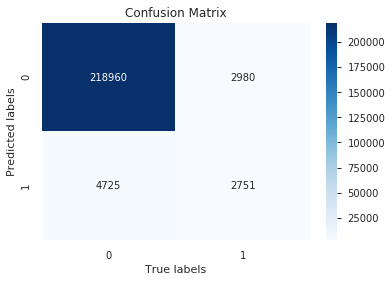

In [30]:
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax = ax)
ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

## 4.3 Sensitivity(Recall) and Precision

In [31]:
print(cr)

print('Precision:', str(round(cm[0][0] * 100 / (cm[0][0] + cm[1][0]), 2)) + '%')
print('Sensitivity:', str(round(cm[0][0] * 100 / (cm[0][0] + cm[0][1]),2)) + '%')
print('Specificity:', str(round((cm[1][1] *100 / (cm[1][1] + cm[0][1])),2)) + '%')


              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98    221940
         1.0       0.48      0.37      0.42      7476

    accuracy                           0.97    229416
   macro avg       0.73      0.68      0.70    229416
weighted avg       0.96      0.97      0.96    229416

Precision: 97.89%
Sensitivity: 98.66%
Specificity: 48.0%


### Sensitivity = True Positives / (True Positives + False Negatives)
    Recall metric shows how many relevant samples are selected, which means how well our model can predict all the interested samples in our dataset.
### Precision = True Positives / (True Positives + False Positives)
    Precision metric tells us how many predicted samples are relevant i.e. our mistakes into classifying sample as a correct one if it’s not true.
### Specificity = 1 - (False Positives / (False Positives + True Negatives))
    Protability that for good SNP (0) classification will be correct (0)

## 4.4 Balanced accuracy score 
### The balanced_accuracy_score function computes the balanced accuracy, which avoids inflated performance estimates on imbalanced datasets. It is the macro-average of recall scores per class or, equivalently, raw accuracy where each sample is weighted according to the inverse prevalence of its true class. Thus for balanced datasets, the score is equal to accuracy. In the binary case, balanced accuracy is equal to the arithmetic mean of sensitivity (true positive rate) and specificity (true negative rate), or the area under the ROC curve with binary predictions rather than scores. [https://scikit-learn.org/ ]

In [32]:
balanced_accuracy_score(y_test, y_pred_class)

0.6772752378666974

## 4.5 Matthews Correlation Coefficient
### The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient. In the binary case TP, TN, FP and FN are respectively the number of true positives, true negatives, false positives and false negatives, the MCC is defined as : 

$ MCC = \frac{tp \times tn - fp \times fn}{\sqrt{(tp + fp)(tp + fn)(tn + fp)(tn + fn)}}. $

In [33]:
matthews_corrcoef(y_test, y_pred_class)

0.40336375795068147

# 5. Plots

## 5.1 Plot show difference between increase F1 score in train and test data. We can see how F1 score was changing threw epochs, that's really cool and coomon plot, but not necessary.

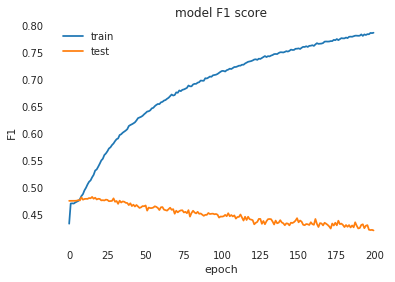

In [34]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model F1 score')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 5.2 Plot - differance between decline in loss and validation loss. 

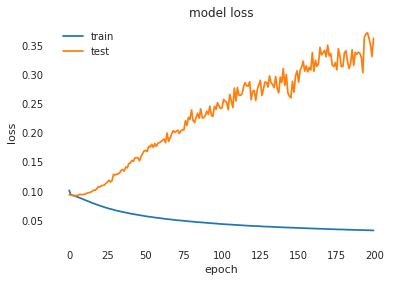

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 5.3 ROC PLOT.
### We can see area under curve which value is the same as our balanced accuracy score. It tells us how good our NN is. The more convex, the better. 

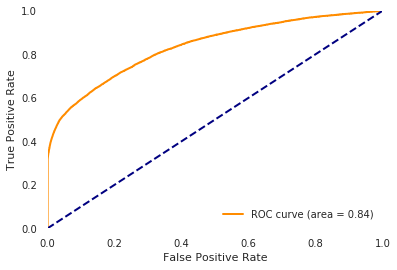

In [62]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr,color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.legend(loc="lower right")
  plt.show()    
  
plot_roc_curve (fpr,tpr)

# 6. Second Neural Network with weights.
## The most important thing there is that I gave weights for our class. It's popular in inbalanced data, becouse we raise value of minority class. 
* Large Weight: Assigned to examples from the minority class.
* Small Weight: Assigned to examples from the majority class.

## I used this time dropout method to prevent overfitting, becouse we could see that early stopping isn't really good with our data. 

In [100]:
model = Sequential()
model.add(Dense(512, input_shape=(134,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=[f1_m])

In [101]:
weights = {0:1, 1:5}
history = model.fit(x_train, y_train,
          class_weight=weights,
          batch_size=512, 
          epochs=100,
          validation_data=(x_val, y_val))

Train on 1858261 samples, validate on 206474 samples
Epoch 1/100
1858261/1858261 [==============================] - 42s 22us/step - loss: 0.3267 - f1_m: 0.4469 - val_loss: 0.1485 - val_f1_m: 0.4762
Epoch 2/100
1858261/1858261 [==============================] - 41s 22us/step - loss: 0.3104 - f1_m: 0.4632 - val_loss: 0.1376 - val_f1_m: 0.4857
Epoch 3/100
1858261/1858261 [==============================] - 41s 22us/step - loss: 0.3069 - f1_m: 0.4657 - val_loss: 0.1439 - val_f1_m: 0.4867
Epoch 4/100
1858261/1858261 [==============================] - 41s 22us/step - loss: 0.3051 - f1_m: 0.4680 - val_loss: 0.1495 - val_f1_m: 0.4883
Epoch 5/100
1858261/1858261 [==============================] - 41s 22us/step - loss: 0.3029 - f1_m: 0.4694 - val_loss: 0.1408 - val_f1_m: 0.4861
Epoch 6/100
1858261/1858261 [==============================] - 41s 22us/step - loss: 0.3017 - f1_m: 0.4709 - val_loss: 0.1470 - val_f1_m: 0.4816
Epoch 7/100
1858261/1858261 [==============================] - 42s 22us/step 

Epoch 57/100
1858261/1858261 [==============================] - 41s 22us/step - loss: 0.2661 - f1_m: 0.4856 - val_loss: 0.1394 - val_f1_m: 0.4832
Epoch 58/100
1858261/1858261 [==============================] - 41s 22us/step - loss: 0.2660 - f1_m: 0.4849 - val_loss: 0.1513 - val_f1_m: 0.4767
Epoch 59/100
1858261/1858261 [==============================] - 41s 22us/step - loss: 0.2655 - f1_m: 0.4837 - val_loss: 0.1426 - val_f1_m: 0.4790
Epoch 60/100
1858261/1858261 [==============================] - 41s 22us/step - loss: 0.2650 - f1_m: 0.4828 - val_loss: 0.1521 - val_f1_m: 0.4705
Epoch 61/100
1858261/1858261 [==============================] - 41s 22us/step - loss: 0.2647 - f1_m: 0.4830 - val_loss: 0.1402 - val_f1_m: 0.4707
Epoch 62/100
1858261/1858261 [==============================] - 41s 22us/step - loss: 0.2643 - f1_m: 0.4842 - val_loss: 0.1435 - val_f1_m: 0.4777
Epoch 63/100
1858261/1858261 [==============================] - 41s 22us/step - loss: 0.2643 - f1_m: 0.4847 - val_loss: 0.14

# 7. Results

In [102]:
results = model.evaluate(x_test, y_test)
print('loss: ', results[0])
print('F1-score: ', results[1])

229416/229416 [==============================] - 8s 34us/step
loss:  0.15041480135174815
F1-score:  0.2547178268432617


## 7.1 Confusion matrix

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

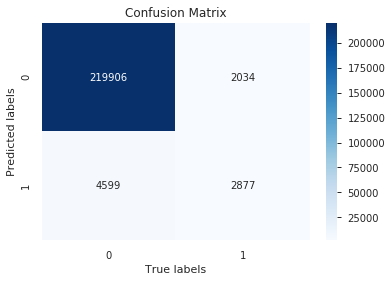

In [103]:
y_pred = model.predict(x_test)
y_pred_class = model.predict_classes(x_test)
cm = confusion_matrix(y_test,y_pred_class)
cr = classification_report(y_test,y_pred_class)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax = ax)
ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

## 7.2 Other results, same as earlier

In [116]:
print(cr)

print('Precision:', str(round(cm[0][0] * 100 / (cm[0][0] + cm[1][0]), 2)) + '%')
print('Sensitivity(Recall):', str(round(cm[0][0] * 100 / (cm[0][0] + cm[0][1]),2)) + '%')
print('Specificity:', str(round((cm[1][1] *100 / (cm[1][1] + cm[0][1])),2)) + '%')

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    369897
         1.0       0.39      0.47      0.43     12461

    accuracy                           0.96    382358
   macro avg       0.69      0.72      0.70    382358
weighted avg       0.96      0.96      0.96    382358

Precision: 98.21%
Sensitivity(Recall): 97.57%
Specificity: 39.49%


### 7.2.1 Balanced Accuracy score

In [105]:
balanced_accuracy_score(y_test, y_pred_class)

0.6878334107912554

### 7.2.2 MCC

In [106]:
matthews_corrcoef(y_test, y_pred_class)

0.4608475698463885

# 8. Plots

## 8.1 F1 score threw epochs 

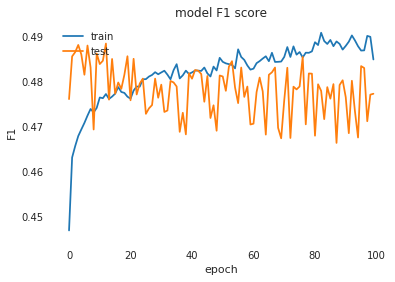

In [107]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model F1 score')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 8.2 Loss threw epochs

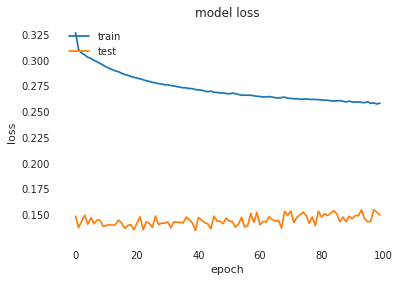

In [108]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 8.3 ROC plot 

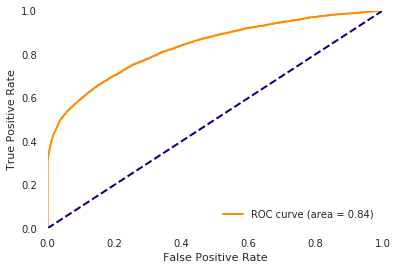

In [109]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)   
plot_roc_curve (fpr,tpr)

---

# 9. Last Neural Network with StratifiedKFold.
## In nutshell StratifedKFold take different part of our data K times for test data and every time there will be same percentage of genotype = 1 in every data. The data will be distributed equally. 
## I made there a ROC PLOT too, becouse that was easy way to create it and show all fold's curve. 

Train on 1720612 samples, validate on 191180 samples
Epoch 1/25
1720612/1720612 [==============================] - 38s 22us/step - loss: 0.4268 - f1_m: 0.4179 - val_loss: 0.1879 - val_f1_m: 0.4134
Epoch 2/25
1720612/1720612 [==============================] - 37s 22us/step - loss: 0.4053 - f1_m: 0.4323 - val_loss: 0.1683 - val_f1_m: 0.4401
Epoch 3/25
1720612/1720612 [==============================] - 37s 22us/step - loss: 0.4009 - f1_m: 0.4334 - val_loss: 0.1796 - val_f1_m: 0.4423
Epoch 4/25
1720612/1720612 [==============================] - 38s 22us/step - loss: 0.3978 - f1_m: 0.4359 - val_loss: 0.1855 - val_f1_m: 0.4355
Epoch 5/25
1720612/1720612 [==============================] - 37s 22us/step - loss: 0.3950 - f1_m: 0.4349 - val_loss: 0.1659 - val_f1_m: 0.4365
Epoch 6/25
1720612/1720612 [==============================] - 37s 22us/step - loss: 0.3921 - f1_m: 0.4344 - val_loss: 0.1713 - val_f1_m: 0.4334
Epoch 7/25
1720612/1720612 [==============================] - 38s 22us/step - loss:

1720613/1720613 [==============================] - 38s 22us/step - loss: 0.3830 - f1_m: 0.4372 - val_loss: 0.1669 - val_f1_m: 0.4474
Epoch 11/25
1720613/1720613 [==============================] - 38s 22us/step - loss: 0.3809 - f1_m: 0.4374 - val_loss: 0.1726 - val_f1_m: 0.4299
Epoch 12/25
1720613/1720613 [==============================] - 39s 22us/step - loss: 0.3785 - f1_m: 0.4413 - val_loss: 0.1716 - val_f1_m: 0.4421
Epoch 13/25
1720613/1720613 [==============================] - 38s 22us/step - loss: 0.3760 - f1_m: 0.4384 - val_loss: 0.1780 - val_f1_m: 0.4338
Epoch 14/25
1720613/1720613 [==============================] - 38s 22us/step - loss: 0.3735 - f1_m: 0.4370 - val_loss: 0.1786 - val_f1_m: 0.4158
Epoch 15/25
1720613/1720613 [==============================] - 40s 23us/step - loss: 0.3723 - f1_m: 0.4395 - val_loss: 0.1829 - val_f1_m: 0.4286
Epoch 16/25
1720613/1720613 [==============================] - 41s 24us/step - loss: 0.3696 - f1_m: 0.4397 - val_loss: 0.1794 - val_f1_m: 0.44

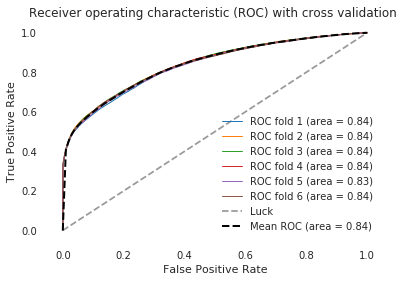

In [110]:
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=3)
models_results = []
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
i = 1
for train_index, test_index in skf.split(data_x, data_y):
    x_train, x_test = data_x.iloc[train_index], data_x.iloc[test_index]
    y_train, y_test = data_y.iloc[train_index], data_y.iloc[test_index]
    
    standardize('QUAL')
    standardize('DP')
    standardize('CALL')
    standardize('DP2')
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.1, random_state=11)
    
    model = Sequential()
    model.add(Dense(512, input_shape=(134,), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=[f1_m])
    weights = {0:1, 1:7.5}
    history = model.fit(x_train, y_train,
              class_weight=weights,
              batch_size=512, 
              epochs=25,
              validation_data=(x_val, y_val))
    
    loss_and_f1 = model.evaluate(x_test, y_test)
    y_pred = model.predict(x_test)
    y_pred_class = model.predict_classes(x_test)
    cm = confusion_matrix(y_test,y_pred_class)
    cr = classification_report(y_test,y_pred_class)
    results = (loss_and_f1[0], loss_and_f1[1], cm, cr, y_pred_class, y_test)
    models_results.append(results)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= 6
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
        label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) with cross validation ')
plt.legend(loc="lower right")
plt.show()

# 10. Results

## 10.1 Results for every fold. 

In [112]:
sr_acc = 0
sr_mcc = 0
print('Results for every fold: ' + '\n\n')
for i, j in enumerate(models_results):
    print('-- Fold',i + 1,'--\n')
    print('F1 score:',str(round(j[1], 4) * 100) + '%')
    print('Loss:',round(j[0], 4))
    print('\n' + 'Confusion matrix:' + '\n',j[2])
    print('\n' + 'Precision:', str(round(j[2][0][0] * 100 / (j[2][0][0] + j[2][1][0]),2)) + '%')
    print('Sensitivity(Recall):', str(round(j[2][0][0] * 100 / (j[2][0][0] + j[2][0][1]), 2)) + '%')
    ba_acc = balanced_accuracy_score(j[5], j[4])
    print('\n' + 'Balanced Accuracy Score:(=AUC)', ba_acc )
    sr_acc += ba_acc
    mcc = matthews_corrcoef(j[5], j[4])
    print('\n' + 'MCC:', mcc)
    sr_mcc += mcc
    print('\n',j[3])
    print('\n\n')

Results for every fold: 


-- Fold 1 --

F1 score: 14.19%
Loss: 0.1807

Confusion matrix:
 [[360415   9483]
 [  6618   5843]]

Precision: 98.2%
Sensitivity(Recall): 97.44%

Balanced Accuracy Score:(=AUC) 0.7216330900590151

MCC: 0.40125002217422956

               precision    recall  f1-score   support

         0.0       0.98      0.97      0.98    369898
         1.0       0.38      0.47      0.42     12461

    accuracy                           0.96    382359
   macro avg       0.68      0.72      0.70    382359
weighted avg       0.96      0.96      0.96    382359




-- Fold 2 --

F1 score: 13.850000000000001%
Loss: 0.1742

Confusion matrix:
 [[361789   8109]
 [  6652   5809]]

Precision: 98.19%
Sensitivity(Recall): 97.81%

Balanced Accuracy Score:(=AUC) 0.722126102339374

MCC: 0.4211866905334542

               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    369898
         1.0       0.42      0.47      0.44     12461

    accuracy       

---

## 10.2 Averge results

### 10.2.1 Averge confusion matrix.

In [113]:
sm = models_results[0][2] + models_results[1][2] + models_results[2][2] + models_results[3][2] + models_results[4][2] + models_results[5][2]
av_cm = sm//6

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

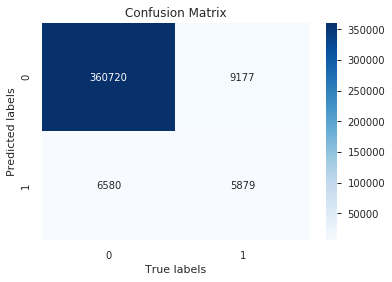

In [114]:
ax= plt.subplot()
sn.heatmap(av_cm, annot=True, fmt='g', cmap="Blues", ax = ax)
ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

### 10.2.2 Averge results for metrics. 

In [121]:
print('Averge results:')
average = str(round((models_results[0][1] + models_results[1][1] + models_results[2][1] + models_results[3][1] + 
                     models_results[4][1] + models_results[5][1]) / 6, 4)*100) + '%'
print('\n' + 'F1 score:', average)
print('Precision:', str(round(av_cm[0][0] * 100 / (av_cm[0][0] + av_cm[1][0]), 2)) + '%')
print('Sensitivity(Recall):', str(round(av_cm[0][0] * 100 / (av_cm[0][0] + av_cm[0][1]),2)) + '%')
print('Mean balanced accuracy score(=AUC):', str(round(sr_acc / 6, 4)))
print('Mean MCC:', str(round(sr_mcc / 6, 4)))

Averge results:

F1 score: 13.930000000000001%
Precision: 98.21%
Sensitivity(Recall): 97.52%
Mean balanced accuracy score(=AUC): 0.7235
Mean MCC: 0.4087


---

# 11. Summary 

|                     | Recall | Precision | balanced accuracy score | MCC   | F1-SCORE |
|---------------------|-------------|-------------|-------------------------|-------|----|
| Frist NN      |  98.66%     |   97.89%    | 0.68                   | 0.40 |23%  |
| Second NN |  99.08% | 97.95% | 0.69                  | 0.46   |25%  |
| Last NN (averge results) | 97.52% | 98.21% | 0.7235 | 0.41 | 13.93% |

# 12. Conclusions 
* Data I was working on is not easy to deal with. There should be a lot more work to do with this, and variables do not describe good and bad genotype well. 
* Best result gave second Neural Network with weigths and dropout method. 
* In first model occur overfitting, so results wasn't really good. 
* Low F1 score in third NN is due to high weigths I used.
* StratifiedKfold could be a good option, but it takes a lot of time to calculate.

# References 
* Training deep neural networks on imbalanced data sets, Authors: Shoujin Wang, Wei Liu, Jia Wu, Longbing Cao, Qinxue Meng, Paul J. Kennedy (2016r.)
* https://www.kaggle.com/parulpandey/10-simple-hacks-to-speed-up-your-data-analysis
* https://www.scipy.org/
* https://scikit-learn.org/stable/
* https://machinelearningmastery.com/cost-sensitive-neural-network-for-imbalanced-classification/